In [1]:
#Validation strategies

In [2]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/ASIF-ISI-KOLKATA/Fraud_Transaction_Detection/blob/main/Baseline_Feature_Transformation.ipynb
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:08 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:09 --:--:--     0
  0     0    0     0    0     0      0      0 --:--

In [3]:
#Training performance versus test performance

In [4]:
#Let us first load the simulated data, and set the output feature and input features as in the section Model training : Decision tree
# Note: We load more data than three weeks, as the experiments in the next sections
# will require up to three months of data

# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
Wall time: 9.44 s
937138 transactions loaded, containing 8139 fraudulent transactions


In [5]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7

In [6]:
def get_performances_train_test_sets(transactions_df, classifier,
                                     input_features, output_feature,
                                     start_date_training, 
                                     delta_train=7, delta_delay=7, delta_test=7,
                                     top_k_list=[100],
                                     type_test="Test", parameter_summary=""):

    # Get the training and test sets
    (train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                           delta_train=delta_train,
                                           delta_delay=delta_delay,
                                           delta_test=delta_test)
    
    # Fit model
    start_time=time.time() 
    model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
    execution_time=time.time()-start_time
    
    # Compute fraud detection performances
    test_df['predictions']=model_and_predictions_dictionary['predictions_test']
    performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
    performances_df_test.columns=performances_df_test.columns.values+' '+type_test
    
    train_df['predictions']=model_and_predictions_dictionary['predictions_train']
    performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
    performances_df_train.columns=performances_df_train.columns.values+' Train'
    
    performances_df=pd.concat([performances_df_test,performances_df_train],axis=1)
    
    performances_df['Execution time']=execution_time
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df

In [7]:
#Let us for example compute the test and training accuracies using a decision tree with depth 2
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=0)

performances_df=get_performances_train_test_sets(transactions_df, classifier, 
                                                 input_features, output_feature,
                                                 start_date_training=start_date_training, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_test=delta_test,
                                                 parameter_summary=2
                                                )

In [8]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.819,0.61,0.281,0.819,0.584,0.421,0.93837,2


In [9]:
#We can then compute the performances for varying decision tree depths. Let us vary the decision tree depths from two to fifty, using the following values: [2,3,4,5,6,7,8,9,10,20,50]
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df=performances_df.append(
        get_performances_train_test_sets(transactions_df, classifier, 
                                         input_features, output_feature, 
                                         start_date_training=start_date_training, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test,            
                                         parameter_summary=max_depth
                           )
    )
    
performances_df.reset_index(inplace=True,drop=True)

In [10]:
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.819,0.610,0.281,0.819,0.584,0.421,0.893011,2
1,0.834,0.642,0.294,0.831,0.628,0.440,1.122586,3
2,0.838,0.646,0.294,0.839,0.651,0.439,1.095195,4
3,0.828,0.628,0.296,0.849,0.675,0.441,1.250967,5
4,0.813,0.599,0.284,0.854,0.690,0.451,1.263964,6
5,0.783,0.572,0.274,0.855,0.702,0.451,1.467707,7
6,0.791,0.566,0.274,0.873,0.710,0.454,1.238718,8
7,0.791,0.567,0.277,0.896,0.745,0.461,1.550323,9
8,0.763,0.559,0.267,0.908,0.774,0.463,1.573451,10
9,0.787,0.470,0.267,0.966,0.891,0.500,2.389371,20


In [11]:
#For better visualization of the results, let us plot the resulting performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth
# Get the performance plot for a single performance metric
def get_performance_plot(performances_df, 
                         ax, 
                         performance_metric, 
                         expe_type_list=['Test','Train'], 
                         expe_type_color_list=['#008000','#2F4D7E'],
                         parameter_name="Tree maximum depth",
                         summary_performances=None):
    
    # expe_type_list is the list of type of experiments, typically containing 'Test', 'Train', or 'Valid'
    # For all types of experiments
    for i in range(len(expe_type_list)):
    
        # Column in performances_df for which to retrieve the data 
        performance_metric_expe_type=performance_metric+' '+expe_type_list[i]
    
        # Plot data on graph
        ax.plot(performances_df['Parameters summary'], performances_df[performance_metric_expe_type], 
                color=expe_type_color_list[i], label = expe_type_list[i])
        
        # If performances_df contains confidence intervals, add them to the graph
        if performance_metric_expe_type+' Std' in performances_df.columns:
        
            conf_min = performances_df[performance_metric_expe_type]\
                        -2*performances_df[performance_metric_expe_type+' Std']
            conf_max = performances_df[performance_metric_expe_type]\
                        +2*performances_df[performance_metric_expe_type+' Std']
    
            ax.fill_between(performances_df['Parameters summary'], conf_min, conf_max, color=expe_type_color_list[i], alpha=.1)

    # If summary_performances table is present, adds vertical dashed bar for best estimated parameter 
    if summary_performances is not None:
        best_estimated_parameter=summary_performances[performance_metric][['Best estimated parameters ($k^*$)']].values[0]
        best_estimated_performance=float(summary_performances[performance_metric][['Validation performance']].values[0].split("+/-")[0])
        ymin, ymax = ax.get_ylim()
        ax.vlines(best_estimated_parameter, ymin, best_estimated_performance,
                  linestyles="dashed")
    
    # Set title, and x and y axes labels
    ax.set_title(performance_metric+'\n', fontsize=14)
    ax.set(xlabel = parameter_name, ylabel=performance_metric)

# Get the performance plots for a set of performance metric
def get_performances_plots(performances_df, 
                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                           expe_type_list=['Test','Train'], expe_type_color_list=['#008000','#2F4D7E'],
                           parameter_name="Tree maximum depth",
                           summary_performances=None):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_performance_plot(performances_df, ax[i], performance_metric=performance_metrics_list[i], 
                             expe_type_list=expe_type_list, 
                             expe_type_color_list=expe_type_color_list,
                             parameter_name=parameter_name,
                             summary_performances=summary_performances)
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=expe_type_list, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Type set")

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

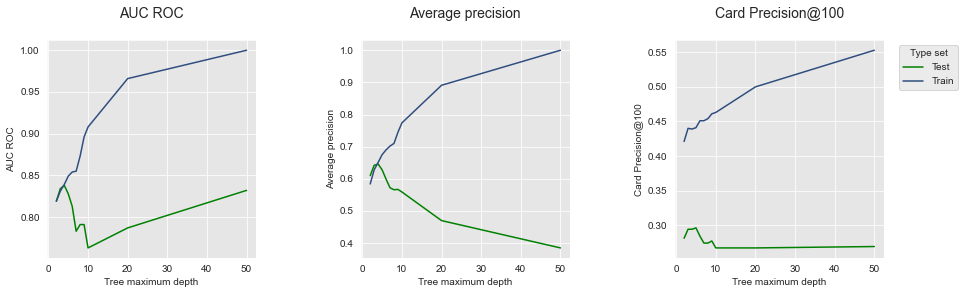

In [12]:
get_performances_plots(performances_df, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Train'],expe_type_color_list=['#008000','#2F4D7E'])

In [13]:
#Hold-out validation

In [14]:
#As an example, we can start with a a decision tree of depth 2
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

performances_df_validation=get_performances_train_test_sets(transactions_df, 
                                                            classifier, 
                                                            input_features, output_feature,
                                                            start_date_training=start_date_training_with_valid, 
                                                            delta_train=delta_train, 
                                                            delta_delay=delta_delay, 
                                                            delta_test=delta_test,
                                                            type_test='Validation', parameter_summary='2')

In [15]:
performances_df_validation

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.811,0.57,0.291,0.821,0.606,0.413,0.909099,2


In [16]:
#Let us compare the results with those obtained in the previous section
performances_df[:1]

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.819,0.61,0.281,0.819,0.584,0.421,0.893011,2


In [17]:
#Let us then compute the expected performances for different depths of decision trees (with values [2,3,4,5,6,7,8,9,10,20,50])
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_validation=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_validation=performances_df_validation.append(
        get_performances_train_test_sets(transactions_df, 
                                         classifier,
                                         input_features, output_feature,
                                         start_date_training=start_date_training_with_valid, 
                                         delta_train=delta_train, 
                                         delta_delay=delta_delay, 
                                         delta_test=delta_test, 
                                         type_test='Validation', parameter_summary=max_depth
                                        )
    )
    
performances_df_validation.reset_index(inplace=True,drop=True)

In [18]:
performances_df_validation

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.811,0.570,0.291,0.821,0.606,0.413,0.963026,2
1,0.830,0.612,0.310,0.835,0.649,0.433,0.961616,3
2,0.830,0.617,0.310,0.839,0.663,0.433,1.100785,4
3,0.804,0.569,0.299,0.841,0.675,0.434,1.020798,5
4,0.789,0.545,0.296,0.844,0.685,0.440,1.690715,6
5,0.806,0.545,0.296,0.859,0.695,0.441,1.418046,7
6,0.784,0.559,0.287,0.881,0.714,0.444,1.412282,8
7,0.759,0.522,0.279,0.892,0.756,0.453,1.533738,9
8,0.754,0.531,0.274,0.895,0.765,0.457,1.558795,10
9,0.806,0.493,0.287,0.980,0.910,0.526,2.196491,20


In [19]:
#For better visualization, let us plot the validation and test performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth
performances_df_validation['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_validation['Average precision Test']=performances_df['Average precision Test']
performances_df_validation['Card Precision@100 Test']=performances_df['Card Precision@100 Test']

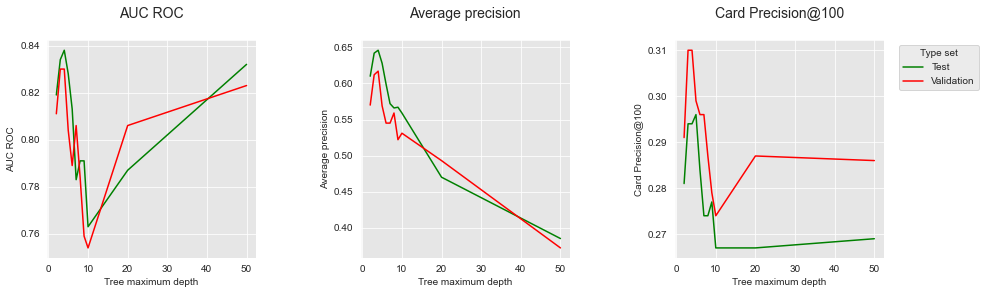

In [20]:
get_performances_plots(performances_df_validation, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000'])

In [21]:
#Repeated hold-out validation

In [22]:
def repeated_holdout_validation(transactions_df, classifier, 
                                start_date_training, 
                                delta_train=7, delta_delay=7, delta_test=7,
                                n_folds=4,
                                sampling_ratio=0.7,
                                top_k_list=[100],
                                type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        # Get the training and test sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test,
                                               sampling_ratio=sampling_ratio,
                                               random_state=fold)
    
        
        # Fit model  
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                         input_features, output_feature)
        
        # Compute fraud detection performances
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds

In [23]:
#Let us for example compute the validation accuracy with a decision tree of depth 2
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

performances_df_repeated_holdout_summary, \
performances_df_repeated_holdout_folds=repeated_holdout_validation(
    transactions_df, classifier, 
    start_date_training=start_date_training_with_valid, 
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_test=delta_test, 
    n_folds=4,
    sampling_ratio=0.7,
    type_test="Validation", parameter_summary='2'
)

In [24]:
performances_df_repeated_holdout_summary

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.81075,0.56575,0.2915,0.82225,0.60725,0.31,0.001639,0.002861,0.001658,0.00798,0.013498,0.007969,5.300517,2


In [25]:
performances_df_repeated_holdout_folds

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train
0,0.812,0.568,0.293,0.833,0.625,0.316
0,0.811,0.568,0.291,0.820,0.609,0.317
0,0.808,0.561,0.289,0.811,0.587,0.297
0,0.812,0.566,0.293,0.825,0.608,0.310


In [26]:
#Let us then compute the expected performances for different depths of decision trees (with values [2,3,4,5,6,7,8,9,10,20,50])
list_params = [2,3,4,5,6,7,8,9,10,20,50]

performances_df_repeated_holdout=pd.DataFrame()

start_time=time.time()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_repeated_holdout=performances_df_repeated_holdout.append(
        repeated_holdout_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_test=delta_test,
            n_folds=4,
            sampling_ratio=0.7,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_repeated_holdout.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 68.33s


In [27]:
performances_df_repeated_holdout

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.81075,0.56575,0.29150,0.82225,0.60725,0.31000,0.001639,0.002861,0.001658,0.007980,0.013498,0.007969,5.747618,2
1,0.82900,0.61125,0.30975,0.83600,0.65025,0.32300,0.000707,0.003345,0.000433,0.008216,0.015122,0.009407,5.948166,3
2,0.82600,0.60975,0.30775,0.83975,0.66750,0.32425,0.004528,0.013179,0.002773,0.008842,0.015772,0.009808,5.818386,4
3,0.82000,0.57125,0.30425,0.84800,0.68325,0.32850,0.005431,0.023552,0.003419,0.011640,0.016947,0.011800,5.855507,5
4,0.78600,0.53800,0.29100,0.85525,0.69875,0.33075,0.013546,0.028539,0.004950,0.007693,0.018525,0.011966,5.935699,6
5,0.75925,0.51875,0.27750,0.86850,0.71000,0.33475,0.024519,0.023413,0.011413,0.011800,0.013583,0.015205,5.724689,7
6,0.75475,0.49475,0.27250,0.88225,0.73550,0.33750,0.006057,0.011031,0.004387,0.011454,0.019007,0.010500,5.565409,8
7,0.75000,0.49400,0.27225,0.89475,0.75100,0.34400,0.005385,0.005788,0.004918,0.008983,0.021024,0.011203,5.847517,9
8,0.75775,0.49650,0.27300,0.91275,0.77750,0.34750,0.013700,0.014517,0.006164,0.006610,0.012176,0.012540,5.867503,10
9,0.78850,0.41950,0.28125,0.98525,0.93200,0.40900,0.009394,0.014169,0.009417,0.004265,0.013077,0.007649,7.768299,20


In [28]:
#For better vizualization, let us plot the validation and test accuracies in terms of AUC ROC, AP, and CP@100 as a function of the decision tree depth
performances_df

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,Execution time,Parameters summary
0,0.819,0.610,0.281,0.819,0.584,0.421,0.893011,2
1,0.834,0.642,0.294,0.831,0.628,0.440,1.122586,3
2,0.838,0.646,0.294,0.839,0.651,0.439,1.095195,4
3,0.828,0.628,0.296,0.849,0.675,0.441,1.250967,5
4,0.813,0.599,0.284,0.854,0.690,0.451,1.263964,6
5,0.783,0.572,0.274,0.855,0.702,0.451,1.467707,7
6,0.791,0.566,0.274,0.873,0.710,0.454,1.238718,8
7,0.791,0.567,0.277,0.896,0.745,0.461,1.550323,9
8,0.763,0.559,0.267,0.908,0.774,0.463,1.573451,10
9,0.787,0.470,0.267,0.966,0.891,0.500,2.389371,20


In [29]:
performances_df_repeated_holdout['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_repeated_holdout['Average precision Test']=performances_df['Average precision Test']
performances_df_repeated_holdout['Card Precision@100 Test']=performances_df['Card Precision@100 Test']

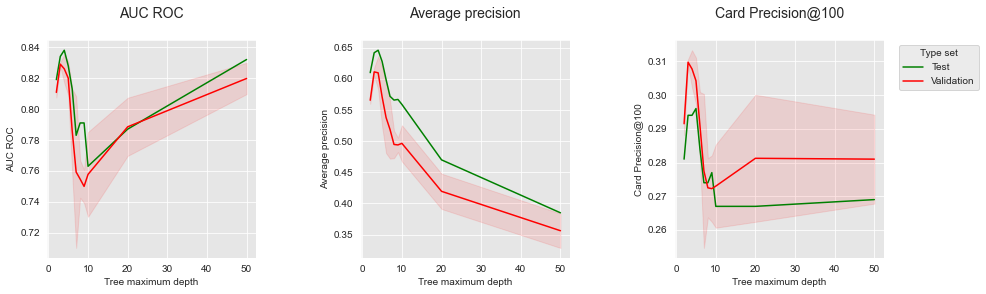

In [30]:
get_performances_plots(
    performances_df_repeated_holdout, 
    performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
    expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000']
)

In [31]:
#Prequential validation

In [32]:
def prequential_validation(transactions_df, classifier, 
                           start_date_training, 
                           delta_train=7, 
                           delta_delay=7, 
                           delta_assessment=7,
                           n_folds=4,
                           top_k_list=[100],
                           type_test="Test", parameter_summary=""):

    performances_df_folds=pd.DataFrame()
    
    start_time=time.time() 
    
    for fold in range(n_folds):
        
        start_date_training_fold=start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,
                                               delta_delay=delta_delay,
                                               delta_test=delta_assessment)
    
        # Fit model
        model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                     input_features, output_feature)
        
        # Compute fraud detection performances    
        test_df['predictions']=model_and_predictions_dictionary['predictions_test']
        performances_df_test=performance_assessment(test_df, top_k_list=top_k_list, rounded=False)
        performances_df_test.columns=performances_df_test.columns.values+' '+type_test
        
        train_df['predictions']=model_and_predictions_dictionary['predictions_train']
        performances_df_train=performance_assessment(train_df, top_k_list=top_k_list, rounded=False)
        performances_df_train.columns=performances_df_train.columns.values+' Train'
    
        performances_df_folds=performances_df_folds.append(pd.concat([performances_df_test,performances_df_train],axis=1))
    
    execution_time=time.time()-start_time
    
    performances_df_folds_mean=performances_df_folds.mean()
    performances_df_folds_std=performances_df_folds.std(ddof=0)
    
    performances_df_folds_mean=pd.DataFrame(performances_df_folds_mean).transpose()
    performances_df_folds_std=pd.DataFrame(performances_df_folds_std).transpose()
    performances_df_folds_std.columns=performances_df_folds_std.columns.values+" Std"
    performances_df=pd.concat([performances_df_folds_mean,performances_df_folds_std],axis=1)
    
    performances_df['Execution time']=execution_time
    
    performances_df['Parameters summary']=parameter_summary
    
    return performances_df, performances_df_folds

In [33]:
#Let us for example compute the validation performance with a decision tree of depth 2
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

performances_df_prequential_summary, performances_df_prequential_folds=prequential_validation(
    transactions_df, classifier, 
    start_date_training=start_date_training_with_valid, 
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid, 
    n_folds=4,
    type_test="Validation", parameter_summary='2'
)

In [34]:
performances_df_prequential_summary

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.794608,0.51549,0.260714,0.804509,0.541324,0.376786,0.018808,0.060289,0.020417,0.016437,0.062693,0.022843,6.086212,2


In [35]:
performances_df_prequential_folds

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train
0,0.811203,0.569566,0.291429,0.820778,0.606407,0.412857
0,0.797976,0.578928,0.264286,0.808883,0.598346,0.368571
0,0.763075,0.438212,0.235714,0.777102,0.460528,0.350000
0,0.806178,0.475255,0.251429,0.811273,0.500015,0.375714


In [36]:
#Let us then compute the expected performances for different depths of decision trees, ranging from [2,3,4,5,6,7,8,9,10,20,50]
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

performances_df_prequential=pd.DataFrame()

for max_depth in list_params:
    
    print("Computing performances for a decision tree with max_depth="+str(max_depth))
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential=performances_df_prequential.append(
        prequential_validation(
            transactions_df, classifier,
            start_date_training=start_date_training_with_valid, 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=4,
            type_test="Validation", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Computing performances for a decision tree with max_depth=2
Computing performances for a decision tree with max_depth=3
Computing performances for a decision tree with max_depth=4
Computing performances for a decision tree with max_depth=5
Computing performances for a decision tree with max_depth=6
Computing performances for a decision tree with max_depth=7
Computing performances for a decision tree with max_depth=8
Computing performances for a decision tree with max_depth=9
Computing performances for a decision tree with max_depth=10
Computing performances for a decision tree with max_depth=20
Computing performances for a decision tree with max_depth=50
Total execution time: 79.18s


In [37]:
performances_df_prequential

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.794608,0.515490,0.260714,0.804509,0.541324,0.376786,0.018808,0.060289,0.020417,0.016437,0.062693,0.022843,5.993173,2
1,0.807881,0.576470,0.274286,0.818466,0.612761,0.395714,0.014856,0.027778,0.022062,0.014149,0.028939,0.022474,6.166183,3
2,0.811839,0.592603,0.276429,0.828889,0.635983,0.399286,0.013812,0.018036,0.019911,0.006027,0.022777,0.019808,6.807766,4
3,0.804012,0.580668,0.271786,0.836827,0.661098,0.401071,0.006447,0.016454,0.016456,0.006419,0.014552,0.019519,6.424699,5
4,0.791430,0.567061,0.271429,0.842016,0.676795,0.407500,0.012864,0.022308,0.015085,0.007878,0.017489,0.019362,6.288294,6
5,0.787812,0.552354,0.268214,0.851721,0.688053,0.407500,0.026211,0.030428,0.017005,0.010316,0.017419,0.020238,6.136649,7
6,0.768977,0.538803,0.258571,0.860053,0.700833,0.410357,0.018690,0.027076,0.017814,0.015572,0.020851,0.020760,6.427869,8
7,0.758872,0.508977,0.253214,0.872385,0.717228,0.416786,0.013057,0.026373,0.017623,0.017875,0.030617,0.023198,6.899670,9
8,0.764171,0.520826,0.260357,0.878898,0.732051,0.421786,0.015684,0.015443,0.010708,0.016837,0.030438,0.022709,7.002814,10
9,0.781357,0.459739,0.260357,0.972697,0.881244,0.479286,0.015683,0.023474,0.017094,0.008226,0.022571,0.031711,10.114217,20


In [38]:
#Let us plot the validation and test performances in terms of AUC ROC, AP, and CP@100, as a function of the decision tree depth
performances_df_prequential['AUC ROC Test']=performances_df['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df['Card Precision@100 Test']

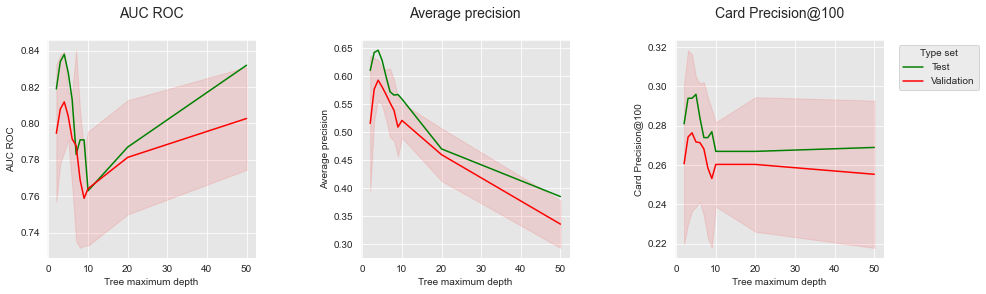

In [39]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

In [40]:
#We can also compute the performances on the next n_folds weeks using the same code, but setting the starting day for training in such a way that estimates for the test period are obtained. This allows to provide confidence intervals for the performances on the test data
list_params = [2,3,4,5,6,7,8,9,10,20,50]

start_time=time.time()

n_folds=4

performances_df_prequential_test=pd.DataFrame()

for max_depth in list_params:
    
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state=0)

    performances_df_prequential_test=performances_df_prequential_test.append(
        prequential_validation(
            transactions_df, classifier, 
            start_date_training=start_date_training 
                +datetime.timedelta(days=delta_test*(n_folds-1)), 
            delta_train=delta_train, 
            delta_delay=delta_delay, 
            delta_assessment=delta_test,
            n_folds=n_folds,
            type_test="Test", parameter_summary=max_depth
        )[0]
    )
    
performances_df_prequential_test.reset_index(inplace=True,drop=True)

print("Total execution time: "+str(round(time.time()-start_time,2))+"s")

Total execution time: 78.46s


In [41]:
performances_df_prequential_test

,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Test Std,Average precision Test Std,Card Precision@100 Test Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary
0,0.803231,0.551173,0.270000,0.819439,0.587194,0.391429,0.016668,0.050648,0.022655,0.016862,0.066474,0.024391,6.389778,2
1,0.820671,0.612959,0.284643,0.830732,0.641768,0.407500,0.017545,0.043241,0.023504,0.015487,0.031620,0.023525,5.360912,3
2,0.816527,0.606828,0.282500,0.841496,0.666965,0.409643,0.019515,0.054507,0.023763,0.015255,0.031725,0.021955,6.408197,4
3,0.801922,0.594158,0.278214,0.848297,0.686111,0.414643,0.021198,0.039054,0.017035,0.013209,0.029280,0.018472,6.983264,5
4,0.793539,0.580718,0.272500,0.857042,0.699197,0.418571,0.027146,0.039895,0.014156,0.009636,0.027126,0.023669,6.671493,6
5,0.784903,0.556300,0.268929,0.868623,0.712762,0.420357,0.017319,0.034498,0.014476,0.017631,0.020991,0.021390,6.112372,7
6,0.787678,0.559010,0.270000,0.876659,0.732778,0.426429,0.022349,0.036890,0.015452,0.016809,0.029410,0.020466,6.540704,8
7,0.784610,0.556295,0.271429,0.897421,0.747368,0.427857,0.017041,0.030344,0.016506,0.014070,0.025901,0.023787,6.727917,9
8,0.773300,0.553997,0.266429,0.904016,0.765219,0.432500,0.018946,0.034290,0.017971,0.014866,0.023208,0.021603,6.977824,10
9,0.797305,0.478287,0.271429,0.979972,0.901447,0.487143,0.017065,0.021112,0.017350,0.010604,0.018730,0.019949,9.655732,20


In [42]:
#Let us plot the validation and test accuracies in terms of AUC ROC, AP and CP@100, as a function of the decision tree depth
performances_df_prequential['AUC ROC Test']=performances_df_prequential_test['AUC ROC Test']
performances_df_prequential['Average precision Test']=performances_df_prequential_test['Average precision Test']
performances_df_prequential['Card Precision@100 Test']=performances_df_prequential_test['Card Precision@100 Test']
performances_df_prequential['AUC ROC Test Std']=performances_df_prequential_test['AUC ROC Test Std']
performances_df_prequential['Average precision Test Std']=performances_df_prequential_test['Average precision Test Std']
performances_df_prequential['Card Precision@100 Test Std']=performances_df_prequential_test['Card Precision@100 Test Std']

In [43]:
performances_df_prequential

,AUC ROC Validation,Average precision Validation,Card Precision@100 Validation,AUC ROC Train,Average precision Train,Card Precision@100 Train,AUC ROC Validation Std,Average precision Validation Std,Card Precision@100 Validation Std,AUC ROC Train Std,Average precision Train Std,Card Precision@100 Train Std,Execution time,Parameters summary,AUC ROC Test,Average precision Test,Card Precision@100 Test,AUC ROC Test Std,Average precision Test Std,Card Precision@100 Test Std
0,0.794608,0.515490,0.260714,0.804509,0.541324,0.376786,0.018808,0.060289,0.020417,0.016437,0.062693,0.022843,5.993173,2,0.803231,0.551173,0.270000,0.016668,0.050648,0.022655
1,0.807881,0.576470,0.274286,0.818466,0.612761,0.395714,0.014856,0.027778,0.022062,0.014149,0.028939,0.022474,6.166183,3,0.820671,0.612959,0.284643,0.017545,0.043241,0.023504
2,0.811839,0.592603,0.276429,0.828889,0.635983,0.399286,0.013812,0.018036,0.019911,0.006027,0.022777,0.019808,6.807766,4,0.816527,0.606828,0.282500,0.019515,0.054507,0.023763
3,0.804012,0.580668,0.271786,0.836827,0.661098,0.401071,0.006447,0.016454,0.016456,0.006419,0.014552,0.019519,6.424699,5,0.801922,0.594158,0.278214,0.021198,0.039054,0.017035
4,0.791430,0.567061,0.271429,0.842016,0.676795,0.407500,0.012864,0.022308,0.015085,0.007878,0.017489,0.019362,6.288294,6,0.793539,0.580718,0.272500,0.027146,0.039895,0.014156
5,0.787812,0.552354,0.268214,0.851721,0.688053,0.407500,0.026211,0.030428,0.017005,0.010316,0.017419,0.020238,6.136649,7,0.784903,0.556300,0.268929,0.017319,0.034498,0.014476
6,0.768977,0.538803,0.258571,0.860053,0.700833,0.410357,0.018690,0.027076,0.017814,0.015572,0.020851,0.020760,6.427869,8,0.787678,0.559010,0.270000,0.022349,0.036890,0.015452
7,0.758872,0.508977,0.253214,0.872385,0.717228,0.416786,0.013057,0.026373,0.017623,0.017875,0.030617,0.023198,6.899670,9,0.784610,0.556295,0.271429,0.017041,0.030344,0.016506
8,0.764171,0.520826,0.260357,0.878898,0.732051,0.421786,0.015684,0.015443,0.010708,0.016837,0.030438,0.022709,7.002814,10,0.773300,0.553997,0.266429,0.018946,0.034290,0.017971
9,0.781357,0.459739,0.260357,0.972697,0.881244,0.479286,0.015683,0.023474,0.017094,0.008226,0.022571,0.031711,10.114217,20,0.797305,0.478287,0.271429,0.017065,0.021112,0.017350


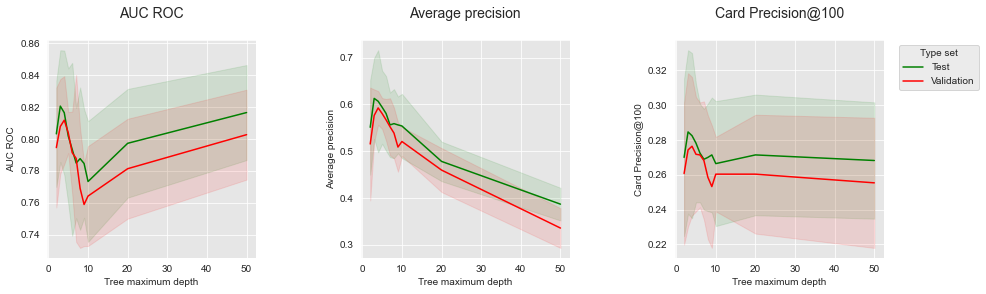

In [44]:
get_performances_plots(performances_df_prequential, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'])

In [45]:
#Integration in Scikit-learn:

In [46]:
#Prequential splitting

In [47]:
#Let us define a prequentialSplit function, that returns the indices of the training and test sets for each of the folds of a prequential split
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

In [48]:
#Card Precision top-k

In [49]:
def card_precision_top_k_custom(y_true, y_pred, top_k, transactions_df):
    
    # Let us create a predictions_df DataFrame, that contains all transactions matching the indices of the current fold
    # (indices of the y_true vector)
    predictions_df=transactions_df.iloc[y_true.index.values].copy()
    predictions_df['predictions']=y_pred
    
    # Compute the CP@k using the function implemented in Chapter 4, Section 4.2
    nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k=\
        card_precision_top_k(predictions_df, top_k)
    
    # Return the mean_card_precision_top_k
    return mean_card_precision_top_k

# Only keep columns that are needed as argument to custome scoring function
# to reduce serialization time of transaction dataset
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Make scorer using card_precision_top_k_custom
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

In [50]:
#Grid search

In [51]:
# Estimator to use
classifier = sklearn.tree.DecisionTreeClassifier()

# Hyperparameters to test
parameters = {'clf__max_depth':[2,4], 'clf__random_state':[0]}

# Scoring functions. AUC ROC and Average Precision are readily available from sklearn 
# with `auc_roc` and `average_precision`. Card Precision@100 was implemented with the make_scorer factory function. 
scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100
           }

# A pipeline is created to scale data before fitting a model
estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
pipe = sklearn.pipeline.Pipeline(estimators)

# Indices for the prequential validation are obtained with the prequentialSplit function
prequential_split_indices = prequentialSplit(transactions_df,
                                             start_date_training_with_valid, 
                                             n_folds=n_folds,
                                             delta_train=delta_train, 
                                             delta_delay=delta_delay, 
                                             delta_assessment=delta_valid)

# Let us instantiate the GridSearchCV
grid_search = sklearn.model_selection.GridSearchCV(pipe, param_grid=parameters, scoring=scoring, \
                                                   cv=prequential_split_indices, refit=False, n_jobs=-1,verbose=0)

# And select the input features, and output feature
X=transactions_df[input_features]
y=transactions_df[output_feature]

In [52]:
%time grid_search.fit(X, y)

print("Finished CV fitting")

Wall time: 42 s
Finished CV fitting


In [53]:
grid_search.cv_results_

{'mean_fit_time': array([1.9556483 , 1.68995321]),
 'std_fit_time': array([0.01850539, 0.006763  ]),
 'mean_score_time': array([0.9637534 , 0.28284651]),
 'std_score_time': array([0.01845154, 0.01135189]),
 'param_clf__max_depth': masked_array(data=[2, 4],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_clf__random_state': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 2, 'clf__random_state': 0},
  {'clf__max_depth': 4, 'clf__random_state': 0}],
 'split0_test_roc_auc': array([0.8112029, 0.8302589]),
 'split1_test_roc_auc': array([0.79797648, 0.79907702]),
 'split2_test_roc_auc': array([0.76307545, 0.79794396]),
 'split3_test_roc_auc': array([0.80617803, 0.8200742 ]),
 'mean_test_roc_auc': array([0.79460821, 0.81183852]),
 'std_test_roc_auc': array([0.01880761, 0.01381169]),
 'rank_test_roc_auc': array([2, 1]),
 'split0_test_average_precision': 

In [54]:
#Let us rearrange these results in a more readable format
performances_df=pd.DataFrame()

expe_type="Validation"

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']


for i in range(len(performance_metrics_list_grid)):
    performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
    performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']

performances_df['Parameters']=list(grid_search.cv_results_['params'])

In [55]:
performances_df

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Execution time,Parameters
0,0.794608,0.018808,0.515490,0.060289,0.260714,0.020417,1.955648,"{'clf__max_depth': 2, 'clf__random_state': 0}"
1,0.811839,0.013812,0.592603,0.018036,0.276429,0.019911,1.689953,"{'clf__max_depth': 4, 'clf__random_state': 0}"


In [56]:
#Integration

In [57]:
#Let us first define a function prequential_grid_search, that implements the grid search as above
def prequential_grid_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    
    return performances_df

        

In [58]:
#We can estimate the validation performances of a decision tree model for varying depth by setting start_date_training to start_date_training_with_valid
start_time=time.time()

classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

performances_df_validation=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training_with_valid,
    n_folds=n_folds,
    expe_type='Validation',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Validation: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Validation: Total execution time: 40.49s


In [59]:
start_time=time.time()

performances_df_test=prequential_grid_search(
    transactions_df, classifier, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test),
    n_folds=n_folds,
    expe_type='Test',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_test,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Test: Total execution time: "+str(round(time.time()-start_time,2))+"s")

Test: Total execution time: 37.74s


In [60]:
#Let us concatenate the validation and test performances in a single DataFrame
performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

In [61]:
# Use the max_depth as the label for plotting
parameters_dict=dict(performances_df['Parameters'])
max_depth=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
performances_df['Parameters summary']=max_depth

In [62]:
performances_df

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.803231,0.016668,0.551173,0.050648,0.270000,0.022655,"{'clf__max_depth': 2, 'clf__random_state': 0}",1.464725,0.794608,0.018808,0.515490,0.060289,0.260714,0.020417,2
1,0.820671,0.017545,0.612959,0.043241,0.284643,0.023504,"{'clf__max_depth': 3, 'clf__random_state': 0}",1.572132,0.807881,0.014856,0.576470,0.027778,0.274286,0.022062,3
2,0.816527,0.019515,0.606828,0.054507,0.282500,0.023763,"{'clf__max_depth': 4, 'clf__random_state': 0}",2.149082,0.811839,0.013812,0.592603,0.018036,0.276429,0.019911,4
3,0.801922,0.021198,0.594158,0.039054,0.278214,0.017035,"{'clf__max_depth': 5, 'clf__random_state': 0}",2.886847,0.804012,0.006447,0.580668,0.016454,0.271786,0.016456,5
4,0.793539,0.027146,0.580718,0.039895,0.272500,0.014156,"{'clf__max_depth': 6, 'clf__random_state': 0}",2.708309,0.791430,0.012864,0.567061,0.022308,0.271429,0.015085,6
5,0.784903,0.017319,0.556300,0.034498,0.268929,0.014476,"{'clf__max_depth': 7, 'clf__random_state': 0}",2.880492,0.787812,0.026211,0.552354,0.030428,0.268214,0.017005,7
6,0.787678,0.022349,0.559010,0.036890,0.270000,0.015452,"{'clf__max_depth': 8, 'clf__random_state': 0}",2.724938,0.768977,0.018690,0.538803,0.027076,0.258571,0.017814,8
7,0.784610,0.017041,0.556295,0.030344,0.271429,0.016506,"{'clf__max_depth': 9, 'clf__random_state': 0}",3.667592,0.758872,0.013057,0.508977,0.026373,0.253214,0.017623,9
8,0.773300,0.018946,0.553997,0.034290,0.266429,0.017971,"{'clf__max_depth': 10, 'clf__random_state': 0}",2.593706,0.764171,0.015684,0.520826,0.015443,0.260357,0.010708,10
9,0.797305,0.017065,0.478287,0.021112,0.271429,0.017350,"{'clf__max_depth': 20, 'clf__random_state': 0}",3.670495,0.781357,0.015683,0.459739,0.023474,0.260357,0.017094,20


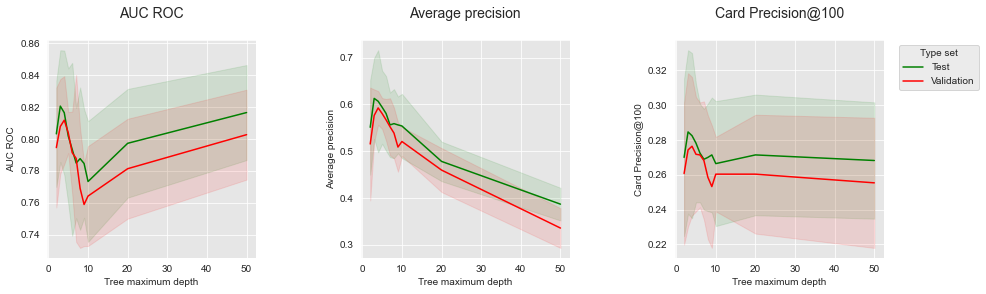

In [63]:
#Let us plot the performances for better visualization
get_performances_plots(performances_df, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'],expe_type_color_list=['#008000','#FF0000'])